# Clasificación de Moda

En este laboratorio se va a entrenar una red neuronal sencilla para la clasificación de imágenes de Ropa en sus respectivas categorías. 

## Objetivos de Aprendizaje

- Familiarizarse con TensorFlow para el entrenamiento de Redes Neuronales
- Recordar los conceptos de Redes Neuronales, Funciones de Costo y Métricas de Evaluación
- Realizar tuneo de hiperparámetros en Redes
- Comparar desempeño contra otros modelos


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# !pip install keras-tuner

In [4]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch, Hyperband


italicized text# 1. Descarga de Información 

La información del Fashion MNIST se encuentra como uno de los DataSets disponibles dentro de TensorFlow. Es posible llamarlo utilizando [`tf.keras.datasets.fashion_mnist`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist).

A continuación, cargue la información de Fashion MNIST. 

Fashion MNIST es un conjunto de datos de imágenes de ropa que se utiliza para entrenar modelos de aprendizaje automático en tareas de clasificación de imágenes. Consiste en 70,000 imágenes en escala de grises de tamaño 28x28 píxeles, divididas en 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Cada imagen pertenece a una de las 10 clases de ropa diferentes, como camisetas, pantalones, zapatos, etc.

Este conjunto de datos se ha convertido en un reemplazo popular para el conjunto de datos MNIST original de dígitos escritos a mano, ya que es un desafío más difícil para los modelos de aprendizaje automático. También se utiliza como un conjunto de datos de referencia para comparar el rendimiento de diferentes algoritmos de clasificación de imágenes.

In [5]:
# Se cargara el data set de imagenes 

###
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

###

El conjunto de datos secompone de 10 clases de ropa para predecir. En la siguiente celda se pueden ver algunos ejemplos de cada categoría.

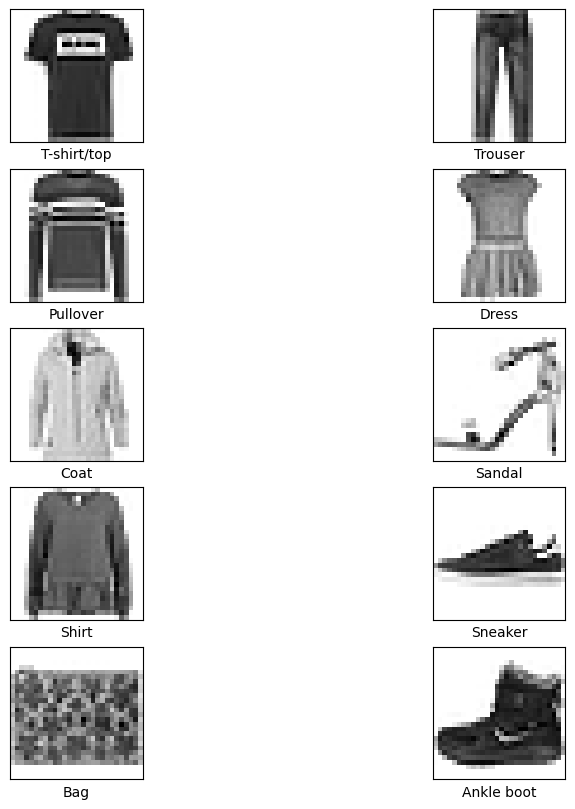

In [6]:
category_indices = [np.where(y_train == i)[0][0] for i in range(10)]
category_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Plot examples
plt.figure(figsize=(10, 10))
for i, index in enumerate(category_indices):
    plt.subplot(5, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[index], cmap=plt.cm.binary)
    plt.xlabel(str(y_train[index]))


    plt.xlabel(category_labels[y_train[index]])
plt.show()

Puede observarse que cada "dato" es una imagen de dimensión 28x28, y que contiene valores de 0 al 255. Donde 0 es un pixel negro, y 255 es un pixel blanco. 

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_train[0, :, :].min(), x_train[0, :, :].max()

(0, 255)

A continuación procedemos a reescalar los datos, de forma que la intensidad del pixel esté en el intervalo [0, 1]. 

In [9]:
# Normalize the pixel values.
x_train = x_train / 255.0
x_test = x_test / 255.0


La función a continuación nos va a permitir observar las predicciones de un modelo y determinar qué tanto se equivocó o no.

In [10]:
def show_random_examples(model, x, y, num_examples=10):
    """
    Selección aleatoria de ejemplos y predicciones.

    Params:
    ---------
      model (tf.keras.Model):
        Modelo de Red Neuronal para predicciones

      x (numpy.array):
        Numpy Array con pixeles de la ropa

      y (numpy.array):
        Numpy Array indicando categoría

    """
    # Muestra Aleatorio de índices
    indices = np.random.choice(range(x.shape[0]), num_examples)

    # Obtención de Imágenes y Categorías de Verdad
    images = x[indices]
    true_labels = y[indices]

    # Generar Predicciones del Modelo
    predictions = model.predict(images) # El modelo predice probabilidades
    predicted_labels = np.argmax(predictions, axis=-1) # Se requiere obtener la categoría que maximice esas probabilidad
    predicted_probs = np.max(predictions, axis=-1) # Selección de Probabilidad de categoría ganadora

    # Display the images, true labels, and predicted labels
    plt.figure(figsize=(10, 5))
    for i, (img, true_label, pred_label, prob) in enumerate(zip(images, true_labels, predicted_labels, predicted_probs)):
        plt.subplot(2, num_examples // 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        title_color = 'red' if true_label != pred_label else 'black'
        plt.title(f"True: {category_labels[true_label]}\nPredicted: {category_labels[pred_label]} ({prob:.2f})", fontsize=10, color=title_color)
    plt.tight_layout()
    plt.show()




In [11]:
y_train.max(), y_train.min()

(9, 0)

# 2. Definición del Modelo

A continuación tendrá que definir un modelo de red neuronal como usted considere. Para esto, tiene a su disposición las capas Densas (fully connected layers) que se encuentran en [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Siéntase libre de explorar con la cantidad de capas ocultas, la cantidad de neuronas, las funciones de activación, etc... 

**Nota:** Recuerde que existen 10 categorías de predicción, por lo que debe escoger adecuadamente el número de neuronas de la capa final y la función de activación de la misma. Puede ver las funciones de activación disponibles en [la documentación de TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 

In [12]:
### Defina el modelo inicial

model = Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), # No borrar, es para garantizar forma
    tf.keras.layers.Dense(392, activation='relu'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(y_train.max() + 1, activation='softmax')]) # son 10 clases y estas empiezan desde 0, por que se debe sumar uno para que la capa softmax quede con las clases necesarias.

###

La red neuronal se inicializó con unos pesos aleatorios. Este es un modelo que prácticamente está adivinando. A continuación, utilice la función `show_random_examples` para determinar qué tan capaz es el modelo antes de comenzar a aprender.

1/1 [==============================] - 0s 231ms/step


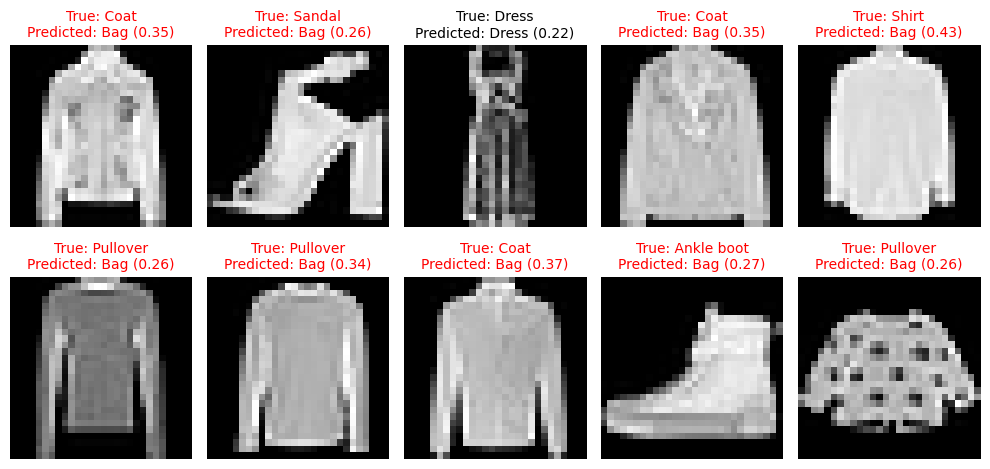

In [13]:
### Utilice la función show_random_examples para mostrar las predicciones en algunos ejemplos
show_random_examples(model, x_test, y_test)
###

Para entrenar el modelo, es necesario definir cuál es el objetivo y cómo se desea hacer. Es por esto que se requiere *compilar* el modelo utilizando el método [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) del API de Tensorflow. 

En este debe definir qué optimizador utilizar, cuál es la función a minimizar y qué métricas de seguimiento se van a evaluar. 

**Nota:** Debido al formato de los datos, se utilizará la función de pérdida [`SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) e igualmente la [`SparseCategoricalAccuracy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy). 

**Nota 2:** Se recomienda utilizar [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) como el optimizador, pero se recomienda probar los otros optimizadores disponibles en [la documentación de TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). 

In [14]:
### Compile el modelo utilizando Sparce Categorical Crossentropy y Accuracy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), ## Pruebe otros Optimizadores
    loss=['SparseCategoricalCrossentropy'], 
    metrics=['SparseCategoricalAccuracy']
)

###


# 3. Entrenamiento de Modelo

Una vez definida la estructura del modelo y el objetivo de entrenamiento, se puede proceder a entrenar. Se utilizará el método `fit` del modelo. Pruebe probar otros batchsizes. 

Utilice el parámetro de `validation_split=0.2` para generar una división automática en validación.

**Nota:** Guarde la historia del modelo en `model_history`, para su posterior análisis.

In [15]:
model_history = model.fit(x_train, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 26s 15ms/step - loss: 0.4971 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.4026 - val_sparse_categorical_accuracy: 0.8539
Epoch 2/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.3723 - val_sparse_categorical_accuracy: 0.8602
Epoch 3/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3408 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.3494 - val_sparse_categorical_accuracy: 0.8722
Epoch 4/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.3405 - val_sparse_categorical_accuracy: 0.8757
Epoch 5/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3027 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.3341 - val_sparse_categorical_accuracy: 0.8817
Epoch 6/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2903 

Una vez entrenado el modelo, se procede a revisar sus predicciones en la base de datos de tes. 

1/1 [==============================] - 0s 111ms/step


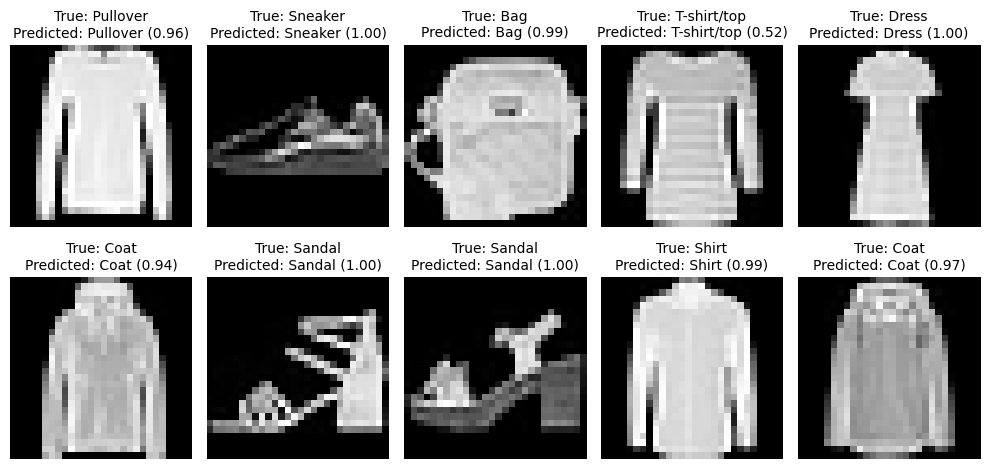

In [16]:
show_random_examples(model, x_test, y_test)

A continuación, utilice el método `evaluate` para determinar el desempeño del modelo en Test. 

In [ ]:
###
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

###


  1/313 [..............................] - ETA: 41s - loss: 0.4766 - sparse_categorical_accuracy: 0.8750

In [ ]:
# Esta función nos permitirá ver la evolución de las métricas del modelo
def plot_training_and_validation_loss(model_history):
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


plot_training_and_validation_loss(model_history)


# 4. Tuneo de Hiperparámetros & Early Stopping

Hasta este punto, únicamente hicimos el entrenamiento del modelo para una especificación fijada por nosotros. Sin embargo, no necesariamente esa es la mejor especificación para el modelo que se está planteando. Es por esta razón que realizaremos el tuneo de hiperparámetros de la red neuronal. 

Adicionalmente, se utilizará el EarlyStopping para evitar entrenar modelos con sobreajuste.

Los hiperparámetros de la red neuronal son:
- Número de Capas
- Número de Neuronas por Capa
- Tasa de Aprendizaje
- Batch Size
- Optimizador
- Funciones de Activación

Debemos encontrar la combinación óptima de hiper-parámetros que genere el mejor modelo. 

Puede consultar información respecto a [`keras_tuner`](https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=es-419) en su documentación. 

## Creación Modelo Base

Para facilitar la exploración del espacio de hiperparámetros del modelo, es necesario crear una clase que permita generar y preparar modelos rápidamente dado los hiperparámetros. 

In [ ]:
###
class FashionMNISTModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Se define el modelo de Red Neuronal
        model = Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=self.input_shape))

        # Definición del Número de Capas
        NUM_LAYERS = hp.Int("num_layers", 1, 3) 
        DROPOUT = hp.Float(f"dropout_rate", 0.1, 0.5, step=0.1)
        for i in range(NUM_LAYERS):
            # Debemos añadir cada una de las capas
            # Pero cada capa debe tener un número de neuronas... 

            NUM_NEURONAS = hp.Int(f"dense_units_{i}", 32, 128, step=32)

            ### 
            # Añada una capa al modelo con el número de neuronas especificado en NUM_NEURONAS
            # No olvide la función de activación
            model.add(None)

            ### 

            ###
            # Añada una capa de Dropout después de cada capa
            model.add(None)

            ###

        # Especifique la capa de salida del modelo

        ###

        model.add(None)

        ###

        LEARNING_RATE = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        model.compile(
            optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        return model



Una vez definido el modelo, podemos instanciar el tuner para entrenar los modelos y encontrar cuál es la mejor combinación de hiperparámetros para nuestro caso.

Existen varias opciones para el tuneador, entre las cuales se encuentra:
- **RandomSearch**: Búsqueda aleatoria de hiperparámetros
- **Hyperband Tuner**: Entrena a los modelos como en una competencia donde cada "ronda" pasa la mitad de modelos con mejor desempeño
- **BayesianOptimization**
- **Sklearn**

In [ ]:
# Incialización del Constructor
input_shape = (28, 28)
hypermodel = FashionMNISTModel(input_shape)

In [ ]:
tuner = Hyperband(hypermodel,
                  objective='val_accuracy',
                  max_epochs=50,
                  directory="tuner_results",
                  project_name="fashion_mnist")

In [ ]:
#help(Hyperband)

El entrenamiento igualmente debemos hacerlo teniendo en cuenta el EarlyStopping para evitar overfitting. Para esto, utilizaremos el Callback de EarlyStopping. 

Adicionalmente, registraremos los resultados del modelo en TensorBoard para su posterior visualización.

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
%tensorboard --logdir logs

In [ ]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping_callback, tensorboard_callback])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Los mejores hiperparámetros encontrados para el modelo son los siguientes...

In [ ]:
best_hps.values

Una vez definido el Tuner, se realiza el entrenamiento como con los modelos normales de Tensorflow. Tenemos que entrenar ya el modelo final con esa información.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
hp_history = model.fit(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[early_stopping_callback])

In [ ]:
plot_training_and_validation_loss(hp_istory)

In [ ]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

# 5. Entrenamiento de XGBoost

A continuación se probará un modelo XGBoost para la predicción de la misma ropa utilizando cada pixel como una variable independiente. Es decir, este modelo tendrá de entrada 784 variables para entrenar. 

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Al igual que para la red neuronal, es necesario convertir la imagen en un vector (28x28) -> (1, 784)

In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0], -1) 
x_test_flat = x_test.reshape(x_test.shape[0], -1) 

Definimos nuestro dataset de validación como:

In [ ]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_flat, y_train, test_size=0.2, random_state=42)

Y se acomodan los datos de entrenamiento en las DMatrix para el modelo.

In [ ]:
dtrain = xgb.DMatrix(x_train_split, label=y_train_split)
dval = xgb.DMatrix(x_val_split, label=y_val_split)
dtest = xgb.DMatrix(x_test_flat, label=y_test)


### Definición del Modelo

En este caso no se realizará búsqueda de hiperparámetros para el XGBoost, pero se recomienda. 

Defina los parámetros de la función objetivo, el número de clases a predecir. Puede guiarse con [la documentación](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters). 

In [ ]:
### 
# Defina los parámetros de XGBoost
params = {
    "objective": None, # Multiclase
    "num_class": None, # Núm Clases
    "max_depth": 6,
    "eta": 0.3,
    "eval_metric": "merror",
}

###


In [ ]:

# Train the XGBoost model
num_rounds = 50
eval_list = [(dtrain, "train"), (dval, "validation")]
bst = xgb.train(params, dtrain, num_rounds, evals=eval_list, early_stopping_rounds=3)


In [ ]:

# Realice sus Predicciones en test
y_pred = bst.predict(dtest)


In [ ]:

# Evalúe el Accuracy del Modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

¿Cuál de los dos modelos presentó mejores resultados (La red Tuneada o el XGBoost)? 
¿Qué métricas debería usar para evaluar?